<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/new_after_bandpass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install flask
!npm install -g localtunnel
!pip install flask flask-ngrok tensorflow joblib pykalman scipy
!pip install PyWavelets

from flask import Flask, jsonify
import numpy as np
from tensorflow.keras.models import load_model
import joblib
from scipy.signal import butter, filtfilt,welch
from pykalman import KalmanFilter
import subprocess
import pywt
from sklearn.decomposition import PCA

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼
added 22 packages in 3s
⠼
⠼3 packages are looking for funding
⠼  run `npm fund` for details
⠼Requirement already satisfied: flask in /usr/local/lib/python3.11/dist-packages (3.1.0)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 248.5/248.5 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 8.4 MB/s eta 0:00:00


 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


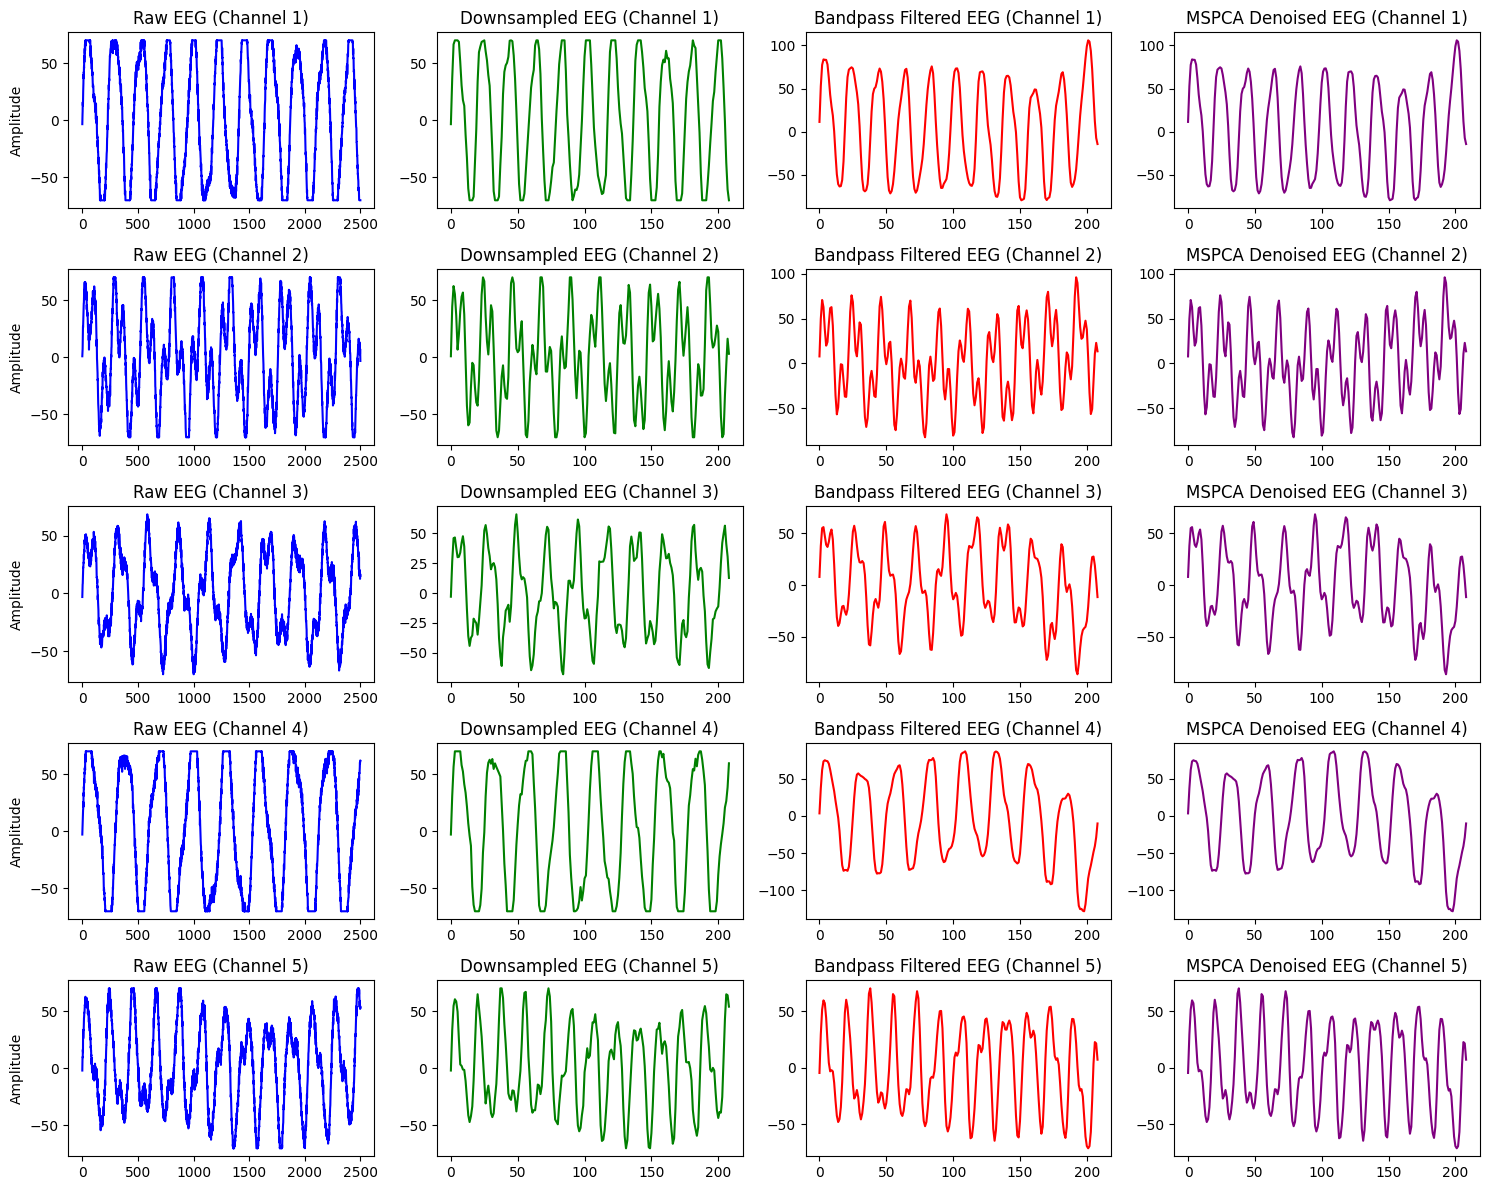

ERROR:__main__:Exception on /predict [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-6-4c19d1e4604a>", line 148, in predict
    sample = extract_de_lds(mspca_eeg).reshape((1, 1, 310))
        

In [6]:
# --- EEG Config ---
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Welch & MSPCA ---
def extract_de_lds(eeg_data):
    eeg_data = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in eeg_data]
    eeg_data = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]
    eeg_data = mspca_denoise(np.array(eeg_data))

    de_features = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=sampling_rate_final, nperseg=min(200, segment_length))
        band_de = []
        for _, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        smoothed_de, _ = kf.filter(np.array(band_de).reshape(-1, 1))
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)

    # Normalize
    de_min, de_max = np.min(de_features), np.max(de_features)
    scaled = 15 + (de_features - de_min) / (de_max - de_min + 1e-8) * (27 - 15)
    return scaled.flatten()

# --- Run Inference ---
eeg_data = generate_eeg()
features = extract_de_lds(eeg_data).reshape((1, 62,5))

# Load model and encoder (ensure the path is correct for Colab)
model = load_model('/content/emotion_model_50_epochs(seed4).h5')
encoder = joblib.load('/content/eeg_label_encoder (seed4) .pkl')

prediction = model.predict(features)
predicted_label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Print result in Colab output
print(f"Predicted Emotion: {predicted_label}")

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


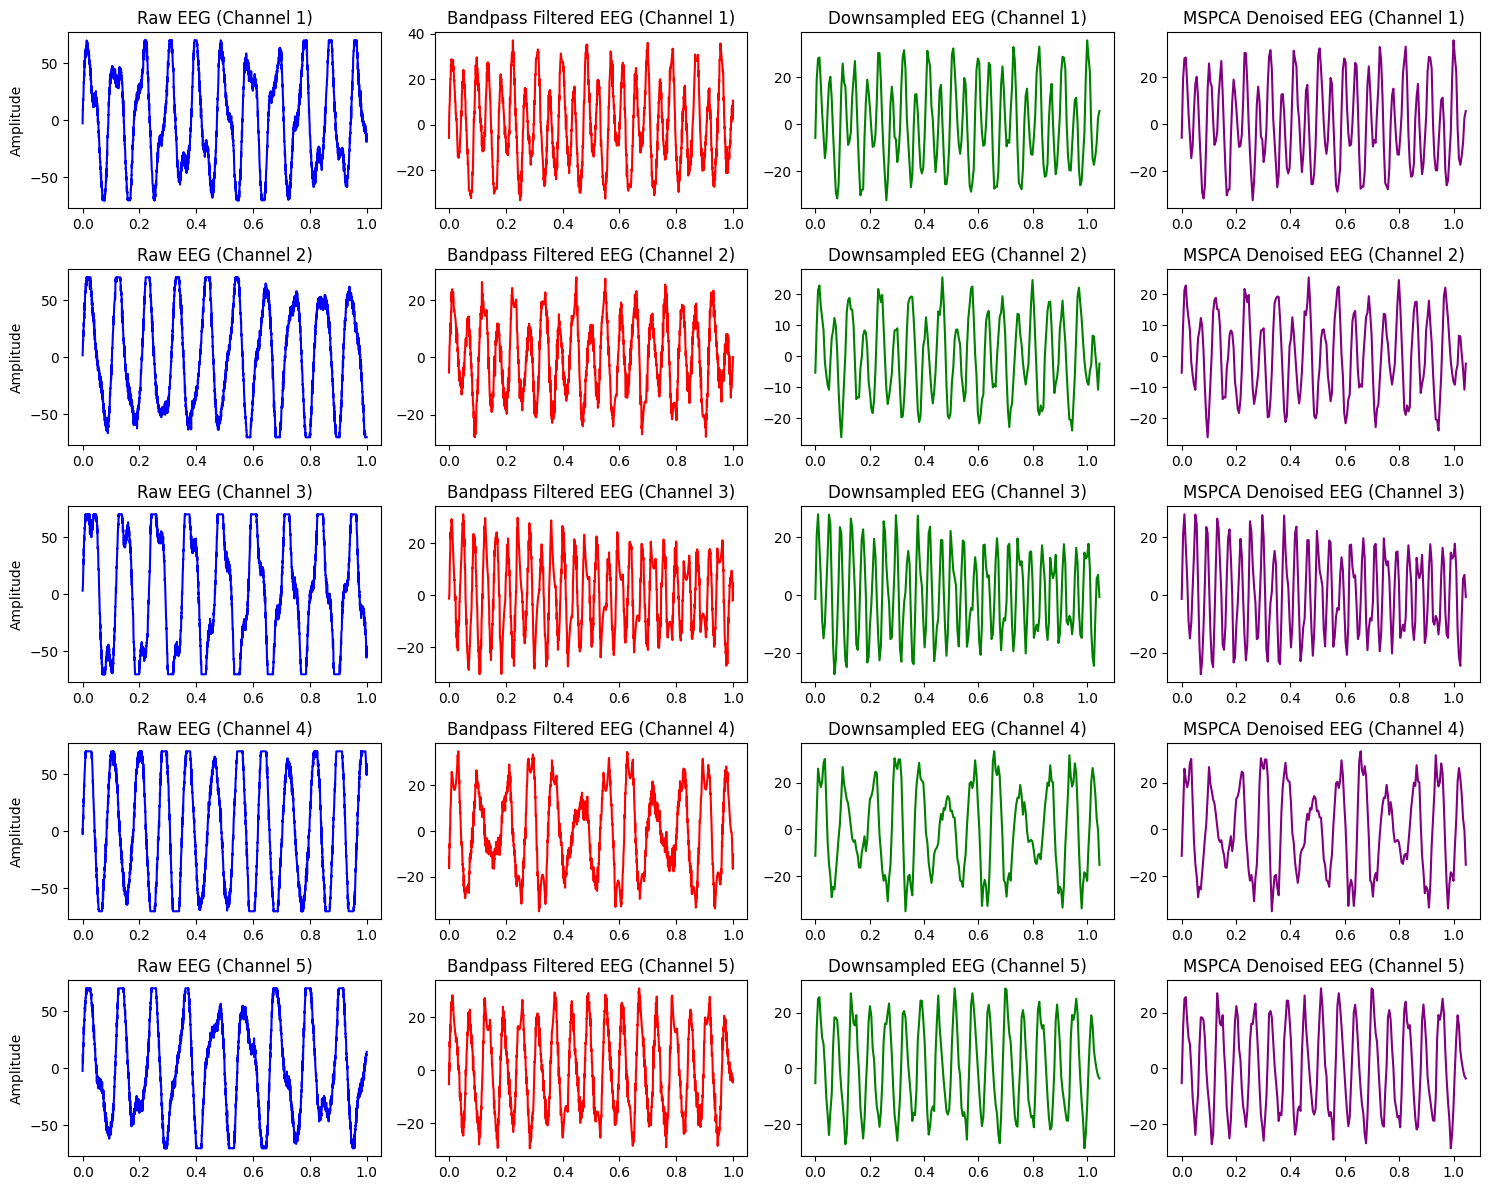

ERROR:__main__:Exception on /predict [GET]
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 1511, in wsgi_app
    response = self.full_dispatch_request()
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 919, in full_dispatch_request
    rv = self.handle_user_exception(e)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 917, in full_dispatch_request
    rv = self.dispatch_request()
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/flask/app.py", line 902, in dispatch_request
    return self.ensure_sync(self.view_functions[rule.endpoint])(**view_args)  # type: ignore[no-any-return]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-2-6c325777aaa9>", line 180, in predict
    sample = extract_de_lds(mspca_eeg).reshape((1, 1.310))
         

In [2]:
from flask import Flask, jsonify
import numpy as np
from scipy.signal import butter, filtfilt, welch
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model
import joblib
import pywt
from sklearn.decomposition import PCA
import subprocess
from threading import Thread
import matplotlib.pyplot as plt

app = Flask(__name__)

# --- EEG Config ---
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Welch & MSPCA ---
def extract_de_lds(eeg_data):
    # eeg_data = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]
    # eeg_data = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in eeg_data]
    # eeg_data = mspca_denoise(np.array(eeg_data))

    de_features = []
    for ch_data in eeg_data:
        freqs, psd = welch(ch_data, fs=sampling_rate_final, nperseg=min(200, segment_length))
        band_de = []
        for _, (low, high) in freq_bands.items():
            band_power = psd[(freqs >= low) & (freqs <= high)]
            band_de_value = 0.5 * np.log(2 * np.pi * np.e * (np.mean(band_power) + 1e-6))
            band_de.append(band_de_value)
        smoothed_de, _ = kf.filter(np.array(band_de).reshape(-1, 1))
        de_features.append(smoothed_de.flatten())
    de_features = np.array(de_features)

    # Normalize
    de_min, de_max = np.min(de_features), np.max(de_features)
    scaled = 15 + (de_features - de_min) / (de_max - de_min + 1e-8) * (27 - 15)
    return scaled.flatten()

# --- Plotting Function ---
# def plot_eeg_signals(raw_eeg, bandpassed_eeg, downsampled_eeg, mspca_eeg, channels=5):
#     fig, axs = plt.subplots(channels, 4, figsize=(15, 12))

#     for i in range(channels):
#         # Raw EEG
#         axs[i, 0].plot(raw_eeg[i], color='b')
#         axs[i, 0].set_title(f'Raw EEG (Channel {i+1})')
#         axs[i, 0].set_ylabel('Amplitude')

#         # Bandpass Filtered EEG
#         axs[i, 1].plot(bandpassed_eeg[i], color='r')
#         axs[i, 1].set_title(f'Bandpass Filtered EEG (Channel {i+1})')

#          # Downsampled EEG
#         axs[i, 2].plot(downsampled_eeg[i], color='g')
#         axs[i, 2].set_title(f'Downsampled EEG (Channel {i+1})')

#         # MSPCA Denoised EEG
#         axs[i, 3].plot(mspca_eeg[i], color='purple')
#         axs[i, 3].set_title(f'MSPCA Denoised EEG (Channel {i+1})')

#     plt.tight_layout()
#     plt.show()

def plot_eeg_signals(raw_eeg, bandpassed_eeg, downsampled_eeg, mspca_eeg, channels=5):
    fig, axs = plt.subplots(channels, 4, figsize=(15, 12))

    duration_raw = len(raw_eeg[0]) / sampling_rate_original
    duration_down = len(downsampled_eeg[0]) / sampling_rate_final

    t_raw = np.linspace(0, duration_raw, len(raw_eeg[0]))
    t_down = np.linspace(0, duration_down, len(downsampled_eeg[0]))

    for i in range(channels):
        # Raw EEG
        axs[i, 0].plot(t_raw, raw_eeg[i], color='b')
        axs[i, 0].set_title(f'Raw EEG (Channel {i+1})')
        axs[i, 0].set_ylabel('Amplitude')

        # Bandpass Filtered EEG
        axs[i, 1].plot(t_raw, bandpassed_eeg[i], color='r')
        axs[i, 1].set_title(f'Bandpass Filtered EEG (Channel {i+1})')

        # Downsampled EEG
        axs[i, 2].plot(t_down, downsampled_eeg[i], color='g')
        axs[i, 2].set_title(f'Downsampled EEG (Channel {i+1})')

        # MSPCA Denoised EEG
        axs[i, 3].plot(t_down, mspca_eeg[i], color='purple')
        axs[i, 3].set_title(f'MSPCA Denoised EEG (Channel {i+1})')

    plt.tight_layout()
    plt.show()

# --- API Route ---
@app.route('/predict', methods=['GET'])
def predict():
    eeg_data = generate_eeg()

     # Bandpass Filter
    bandpassed_eeg = [bandpass_filter(ch, 1, 50, sampling_rate_final) for ch in eeg_data]

    # Downsample
    downsampled_eeg = [downsample(ch, sampling_rate_original, sampling_rate_final) for ch in bandpassed_eeg]



    # MSPCA Denoising
    mspca_eeg = mspca_denoise(np.array(downsampled_eeg))

    # Plot the signals
    plot_eeg_signals(eeg_data, bandpassed_eeg, downsampled_eeg,mspca_eeg)

    # Extract features for model prediction
    sample = extract_de_lds(mspca_eeg).reshape((1, 1.310))

    model = load_model('/content/eeg_emotion_gan_model.h5')
    encoder = joblib.load('/content/eeg_label_encoder.pkl')
    prediction = model.predict(sample)
    label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    print(f"Predicted Emotion: {label}")
    return jsonify({'emotion': label, 'eeg_data': eeg_data.tolist()})

# --- LocalTunnel Setup ---
def run_localtunnel():
    subdomain = "eegemotion"
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())

# --- Run App ---
if __name__ == "__main__":
    from threading import Thread
    # Run LocalTunnel in a separate thread
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)


In [ ]:
!pip install numpy scipy PyWavelets
!pip install scikit-learn filterpy tensorflow joblib


In [19]:
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Band-Split, Welch & MSPCA ---
def extract_de_lds(eeg_data):
    # 1) Downsample all channels
    eeg_ds = [downsample(ch, sampling_rate_original, sampling_rate_final)
              for ch in eeg_data]

    de_features = []  # will become list of 62 vectors of length 5
    for ch in eeg_ds:
        channel_de = []

        for low, high in freq_bands.values():
            # 2) Narrow-band filter
            sig_band = bandpass_filter(ch, low, high, sampling_rate_final)

            # 3) MSPCA denoise _this_ 1D signal
            denoised = mspca_denoise([sig_band])[0]

            # 4) PSD → DE
            freqs, psd = welch(denoised, fs=sampling_rate_final,
                               nperseg=min(200, segment_length))
            P_mean = np.mean(psd)
            de_val = 0.5 * np.log(2 * np.pi * np.e * (P_mean + 1e-6))
            channel_de.append(de_val)

        # 5) Kalman smooth the 5-band DE vector
        smoothed, _ = kf.filter(np.array(channel_de).reshape(-1, 1))
        de_features.append(smoothed.flatten())

    # 6) Normalize & flatten
    feats = np.array(de_features)            # shape (62,5)
    mn, mx = feats.min(), feats.max()
    scaled = 15 + (feats - mn) / (mx - mn + 1e-8) * (27 - 15)
    print(scaled.flatten())
    return scaled.flatten()


# --- Run Inference ---
eeg_data = generate_eeg()
features = extract_de_lds(eeg_data).reshape((1, 62,5))

# Load model and encoder (ensure the path is correct for Colab)
model = load_model('/content/emotion_model_50_epochs(seed4).h5')
encoder = joblib.load('/content/eeg_label_encoder.pkl')

prediction = model.predict(features)
predicted_label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

# Print result in Colab output
print(f"Predicted Emotion: {predicted_label}")


[23.87297618 21.90107929 23.37284905 22.46324703 18.61355229 23.30223879
 16.66462117 20.60428678 21.78436945 17.33749982 24.582432   19.19431955
 22.35295283 22.32482772 18.60986767 23.6670949  18.81681569 22.38407876
 22.44980516 19.72937319 22.84619478 17.24576085 21.49899223 21.67020027
 18.51896741 23.83735208 19.25191216 22.43667298 21.09091047 17.81573359
 22.79999524 16.35751257 21.04753618 21.07735039 18.05983312 24.04418972
 19.6267685  22.92321889 20.61260135 17.84803186 25.44694125 19.7242583
 22.00700392 21.35452054 16.48677311 25.02540968 18.0243948  21.84986188
 22.29118447 19.32693938 22.38220977 19.39036988 22.80371767 22.13317652
 19.68004947 26.29204217 24.4817678  24.06547529 22.35141948 19.89052229
 18.93878358 15.91123425 20.27470886 21.54888724 17.00167278 22.49738124
 17.74434737 21.65845431 21.19865595 17.56714839 24.7746376  16.08007486
 21.03556472 21.72528415 19.84566508 24.33860256 21.29863905 23.02213454
 22.90952247 18.99765576 22.19187646 15.93620695 20.

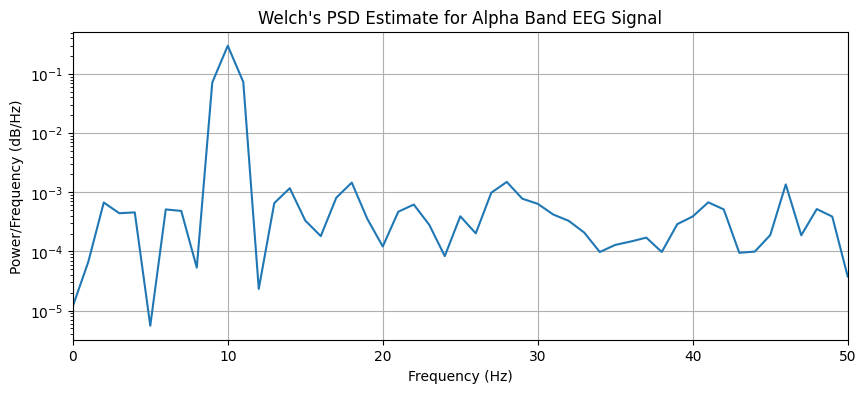

In [18]:
from scipy.signal import welch
import numpy as np
import matplotlib.pyplot as plt

# Simulate a 1-second Alpha-band EEG signal (e.g., 10 Hz sine wave + noise)
fs = 200  # Sampling rate
t = np.linspace(0, 1, fs, endpoint=False)
alpha_wave = np.sin(2 * np.pi * 10 * t) + 0.2 * np.random.randn(len(t))  # 10 Hz + noise

# Apply Welch's method
freqs, psd = welch(alpha_wave, fs=fs, nperseg=min(200, len(t)))

# Plotting for clarity
plt.figure(figsize=(10, 4))
plt.semilogy(freqs, psd)
plt.title("Welch's PSD Estimate for Alpha Band EEG Signal")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power/Frequency (dB/Hz)")
plt.xlim(0, 50)
plt.grid(True)
plt.show()


In [ ]:
# --- Core Libraries ---
import numpy as np
import pywt
import joblib
from scipy.signal import butter, filtfilt, welch
from sklearn.decomposition import PCA
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model


In [20]:
from flask import Flask, jsonify
import numpy as np
from scipy.signal import butter, filtfilt, welch
from pykalman import KalmanFilter
from tensorflow.keras.models import load_model
import joblib
import pywt
from sklearn.decomposition import PCA
import subprocess
from threading import Thread

app = Flask(__name__)

# --- EEG Config ---
sampling_rate_original = 2500
sampling_rate_final = 200
segment_length = sampling_rate_final * 1

freq_bands = {
    "Delta": (1, 4),
    "Theta": (4, 8),
    "Alpha": (8, 14),
    "Beta": (14, 31),
    "Gamma": (31, 50)
}

# --- Kalman Filter Setup ---
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    transition_covariance=0.2 * np.eye(1),
    observation_covariance=0.5 * np.eye(1),
    initial_state_mean=[20],
    initial_state_covariance=5 * np.eye(1)
)

# --- Filtering & Downsampling ---
def bandpass_filter(data, lowcut, highcut, fs):
    nyq = 0.5 * fs
    b, a = butter(4, [lowcut / nyq, highcut / nyq], btype='band')
    return filtfilt(b, a, data)

def downsample(signal, original_fs, target_fs):
    factor = int(original_fs / target_fs)
    return signal[::factor]

# --- EEG Generator ---
def generate_eeg():
    t = np.linspace(0, 1, sampling_rate_original)
    eeg = []
    for _ in range(62):  # 62 EEG channels
        alpha = np.random.uniform(40, 80) * np.sin(2 * np.pi * np.random.uniform(8, 13) * t)
        beta = np.random.uniform(15, 35) * np.sin(2 * np.pi * np.random.uniform(14, 30) * t)
        delta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(1, 3) * t)
        theta = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(4, 7) * t)
        gamma = np.random.uniform(1, 5) * np.sin(2 * np.pi * np.random.uniform(31, 50) * t)
        noise = np.random.normal(0, 3, t.shape)
        signal = delta + theta + alpha + beta + gamma + noise
        eeg.append(np.clip(signal, -70, 70))
    return np.array(eeg)

# --- MSPCA Denoising ---
def mspca_denoise(eeg_data, wavelet='db4', level=4):
    denoised_eeg = []
    for channel in eeg_data:
        coeffs = pywt.wavedec(channel, wavelet, level=level)
        denoised_coeffs = []
        for c in coeffs:
            if len(c) > 1:
                c = c.reshape(-1, 1)
                pca = PCA(n_components=1)
                transformed = pca.fit_transform(c)
                reconstructed = pca.inverse_transform(transformed).flatten()
                denoised_coeffs.append(reconstructed)
            else:
                denoised_coeffs.append(c)
        denoised_signal = pywt.waverec(denoised_coeffs, wavelet)
        denoised_eeg.append(denoised_signal[:len(channel)])
    return np.array(denoised_eeg)

# --- DE_LDS with Band-Split, Welch & MSPCA ---
def extract_de_lds(eeg_data):
    # 1) Downsample all channels
    eeg_ds = [downsample(ch, sampling_rate_original, sampling_rate_final)
              for ch in eeg_data]

    de_features = []  # will become list of 62 vectors of length 5
    for ch in eeg_ds:
        channel_de = []

        for low, high in freq_bands.values():
            # 2) Narrow-band filter
            sig_band = bandpass_filter(ch, low, high, sampling_rate_final)

            # 3) MSPCA denoise _this_ 1D signal
            denoised = mspca_denoise([sig_band])[0]

            # 4) PSD → DE
            freqs, psd = welch(denoised, fs=sampling_rate_final,
                               nperseg=min(200, segment_length))
            P_mean = np.mean(psd)
            de_val = 0.5 * np.log(2 * np.pi * np.e * (P_mean + 1e-6))
            channel_de.append(de_val)

        # 5) Kalman smooth the 5-band DE vector
        smoothed, _ = kf.filter(np.array(channel_de).reshape(-1, 1))
        de_features.append(smoothed.flatten())

    # 6) Normalize & flatten
    feats = np.array(de_features)            # shape (62,5)
    mn, mx = feats.min(), feats.max()
    scaled = 15 + (feats - mn) / (mx - mn + 1e-8) * (27 - 15)
    return scaled.flatten()

# --- Flask API Route ---
@app.route('/predict', methods=['GET'])
def predict():
    eeg_data = generate_eeg()  # Here we use synthetic EEG data for testing
    features = extract_de_lds(eeg_data).reshape((1, 62, 5))  # 1 sample, 62 channels, 5 features

    # Load pre-trained model and encoder
    model = load_model('/content/emotion_model_50_epochs(seed4).h5')  # Path to your model
    encoder = joblib.load('/content/eeg_label_encoder.pkl')  # Path to your label encoder

    # Predict emotion
    prediction = model.predict(features)
    predicted_label = encoder.inverse_transform(np.argmax(prediction, axis=1))[0]

    print(f"Predicted Emotion: {predicted_label}")

    return jsonify({'emotion': predicted_label, 'eeg_data': eeg_data.tolist()})

# --- LocalTunnel Setup ---
def run_localtunnel():
    subdomain = "eegemotion"
    process = subprocess.Popen(['lt', '--port', '5000', '-s', subdomain], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode('utf-8').strip())

# --- Run Flask App ---
if __name__ == "__main__":
    from threading import Thread
    # Run LocalTunnel in a separate thread
    thread = Thread(target=run_localtunnel)
    thread.start()
    app.run(port=5000)  # Starts the Flask app



 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit


your url is: https://eegemotion.loca.lt


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Emotion: Happy


INFO:werkzeug:127.0.0.1 - - [14/May/2025 22:11:55] "GET /predict HTTP/1.1" 200 -
